In [1]:
import pandas as pd
from ada2023.utils import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gzip

## Setup

We process the Wikipedia Request for Adminship (RfA) dataset into a dataframe. We are using a [Wikipedia edit history dataset](https://snap.stanford.edu/data/wiki-meta.html) containing edit up to january 2008. Therefore we filter votes that aren't present in this timeframe.

In [2]:
with gzip.open('../data/wiki-RfA.txt.gz', 'rt', encoding='utf-8') as f:
        blocks = f.read().strip().split('\n\n')  # Assuming each record is separated by a blank line

data = []

# Parse each block of text into a dictionary
for block in blocks:
    record = {}
    for line in block.split('\n'):
        if line:
            key, value = line.split(':', 1)  # Split on the first colon only
            record[key.strip()] = value.strip()
    data.append(record)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

#Rename the columns
df.columns = ['source', 'target', 'vote', 'result', 'year', 'date', 'comment']

#Convert the year, the vote and the result to numeric values
df['year'] = df['year'].astype(int)
df['vote'] = df['vote'].astype(int)
df['result'] = df['result'].astype(int)

#Remove records that are not in the time range present in edit dataset
df = df[df.year < 2009]

#Set of users that are present in the adminship dataset
admin_set = set(df['source'].to_list() + df['target'].to_list())

In [3]:
len(admin_set)

8729

We consider an interaction between two users to be an edit from user A in the user talk page of user B. User talk page ["normal use is for messages from, and discussion with, other editors"](https://en.wikipedia.org/wiki/Wikipedia:User_pages). We filtered edits to keep only interactions from users that where present in the RfA dataset. Using those interactions we created an undirected graph where the weight is the number of interaction between the two users and each node is a user. (TODO : Check with Jeremy for more precise explanation).

In [4]:
G = create_interaction_graph()

We also create a second graph taking into account every user present in the RfA dataset. If a user has not edited the user page of another user, We consider that it had no interactions. They are represented as single nodes.

In [5]:
G_full = create_interaction_graph()

nb_added_nodes = 0

for node in admin_set:
    # Check if the node is not already in the graph
    if node not in G_full.nodes:
        # Add the node to the graph
        G_full.add_node(node)
        nb_added_nodes += 1
print(f"Number of added nodes: {nb_added_nodes}")

Number of added nodes: 2717


To have a better understanding of the interactions, we plot them in a graph. We also plot the degree rank plot and histogram. The degree of a node is the number of edges adjacents to the node. This plot helps us to better understand the distribution of the number of adjacent nodes. We can see that most of the nodes have a low rank. (TODO : Check avec Robin si ok)

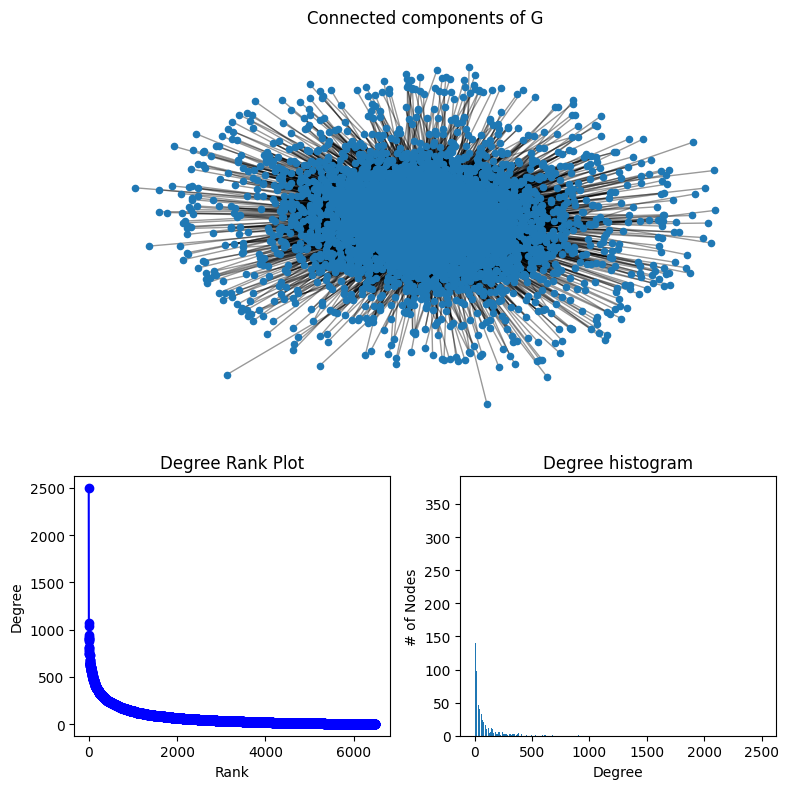

In [6]:
# We sort the nodes in the graph by their degree
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

# Graph of the connected components
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

# Degree rank plot (TODO : demander si ylabel est bien "Degree" ou plutot "# of Nodes")
ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

# Degree histogram
ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [7]:
#We create the communities
communities = nx.community.louvain_communities(G, resolution=1.5, seed=1078)
communities_full = nx.community.louvain_communities(G_full)

We find the two graphs have a large difference in number of communities. This is because nodes without interactions end up being a community on there own.

In [8]:
print(f"Number of communities in graph of users with interactions : {len(communities)}")
print(f"Number of communities in graph of all users : {len(communities_full)}")

Number of communities in graph of users with interactions : 32
Number of communities in graph of all users : 2731


To understand the influence of communities, we compute the probability of vote to be within your community if it was voted at random.

In [9]:
n = len(G) # Number of nodes in the graph
p_same_cluster = 0 # Probability that a random vote is an intra-cluster vote
array_p_same_cluster = np.array([])

# We compute the probability that a random vote is an intra-cluster vote
for c in communities:
    p_same_cluster += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster = np.append(array_p_same_cluster, (len(c)/n)*((len(c)-1)/n))
print(f"Probability that a random vote is an intra-cluster vote in interaction graph : {p_same_cluster}")

Probability that a random vote is an intra-cluster vote in interaction graph : 0.07123917664601835


In [10]:
n = len(G_full)
p_same_cluster_full = 0
array_p_same_cluster_full = np.array([])
for c in communities_full:
    p_same_cluster_full += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster_full = np.append(array_p_same_cluster_full, (len(c)/n)*((len(c)-1)/n))
print(f"Probability that a random vote is an intra-cluster vote in full graph : {p_same_cluster_full}")

Probability that a random vote is an intra-cluster vote in full graph : 0.06746558067966432


In [11]:
# Initialize a counter for votes within the same community
intra_vote_count = np.zeros(len(communities))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities):
        if entity1 in community and entity2 in community:
            intra_vote_count[count] += 1

# Print the result
print(f"Number of votes within the same community : {intra_vote_count.sum()}")

Number of votes within the same community : 20588.0


In [12]:
# Initialize a counter for votes within the same community
intra_vote_count_full = np.zeros(len(communities_full))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities_full):
        if entity1 in community and entity2 in community:
            intra_vote_count_full[count] += 1

# Print the result
print(f"Number of votes within the same community in full graph : {intra_vote_count_full.sum()}")

Number of votes within the same community in full graph : 31001.0


In [13]:
# Create a function to check if entities are in the graph (TODO : Can remove ?)
def are_entities_in_same_community(entity1, entity2):
    for community in communities:
        if entity1 in community:
            for c in communities:
                if entity2 in c:
                    return True
            return False
    return False

# Initialize a counter for votes in the graph
votes_in_the_graph = 0

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the graph
    if entity1 in G and entity2 in G:
        votes_in_the_graph += 1

# Print the result
print(f"Number of votes in the graph : {votes_in_the_graph}")

Number of votes in the graph : 80589


We compare the probability of a random vote and what was observed. The goal is to assess whether the users vote is influenced by its community. We observe that we have a ~3x increase in probability to vote towards your own community in both graphs. (TODO : demander si ça a du sens de faire le graph avec les single nodes parce qu'au final, ça ajoute juste du monde mais ne change pas les communauté)

In [14]:
print("Expected percentage of intra-cluster votes in G:", p_same_cluster * 100)
print("Effective percentage of intra-cluster votes in G:", (intra_vote_count.sum()/votes_in_the_graph)*100)

Expected percentage of intra-cluster votes in G: 7.123917664601835
Effective percentage of intra-cluster votes in G: 25.546910868728983


In [15]:
print("Expected percentage of intra-cluster votes in G1:", p_same_cluster_full * 100)
print("Effective percentage of intra-cluster votes in G1:", (intra_vote_count_full.sum()/len(df))*100)

Expected percentage of intra-cluster votes in G1: 6.746558067966432
Effective percentage of intra-cluster votes in G1: 21.47954658832659


In [16]:
print(f"Number of nodes (users) in the graph : {len(G)}")
print(f"Number of nodes (users) in the full graph : {len(G_full)}")
print(f"Number of users in the RfA dataset : {len(admin_set)}")
print(f"percentage of users in the graph : {(len(G)/len(admin_set))*100}")

Number of nodes (users) in the graph : 6491
Number of nodes (users) in the full graph : 9208
Number of users in the RfA dataset : 8729
percentage of users in the graph : 74.3613243212281


To understand the increase in votes, we compute the expected number of votes if voted at random. Then we make the ratio to derive the multiplicative coefficient from the expected number of votes to observed. 

In [17]:
# expected number of intra-cluster votes
expected_nb_votes = array_p_same_cluster * votes_in_the_graph

In [18]:
array_p_same_cluster

array([5.78030361e-03, 1.40725526e-03, 2.46689769e-02, 7.84656598e-05,
       7.31017036e-04, 1.80143484e-03, 7.83351210e-03, 3.27562088e-03,
       2.07248077e-03, 4.98420707e-06, 8.97869301e-04, 2.25618440e-04,
       4.04195459e-04, 8.97631958e-05, 1.59394942e-02, 4.91300411e-05,
       2.01675258e-03, 8.34403731e-04, 3.70255382e-05, 2.89796039e-04,
       1.42405916e-07, 1.35285620e-04, 2.20729170e-05, 1.24747583e-04,
       1.73497875e-04, 3.44622317e-04, 5.69623665e-06, 5.02455541e-04,
       1.02190485e-03, 1.01820230e-04, 2.99052424e-05, 3.38926080e-04])

In [19]:
intra_vote_count

array([2.950e+02, 2.360e+02, 8.607e+03, 1.800e+01, 2.560e+02, 3.110e+02,
       3.183e+03, 8.780e+02, 3.460e+02, 3.000e+00, 2.900e+02, 1.040e+02,
       9.800e+01, 1.900e+01, 4.654e+03, 1.100e+01, 3.150e+02, 2.430e+02,
       6.000e+00, 9.700e+01, 0.000e+00, 3.000e+01, 1.500e+01, 5.200e+01,
       2.800e+01, 1.350e+02, 7.000e+00, 7.200e+01, 1.320e+02, 6.200e+01,
       1.300e+01, 7.200e+01])

In [20]:
# ratio of effective intra-cluster votes over expected intra-cluster votes
vote_gain = intra_vote_count / expected_nb_votes

In [21]:
for i, c in enumerate(communities):
    print(f"{i} - {len(c)}")


0 - 494
1 - 244
2 - 1020
3 - 58
4 - 176
5 - 276
6 - 575
7 - 372
8 - 296
9 - 15
10 - 195
11 - 98
12 - 131
13 - 62
14 - 820
15 - 46
16 - 292
17 - 188
18 - 40
19 - 111
20 - 3
21 - 76
22 - 31
23 - 73
24 - 86
25 - 121
26 - 16
27 - 146
28 - 208
29 - 66
30 - 36
31 - 120


We want to understand the distribution of votes between communities. For that we plot the distribution of votes between communities

In [22]:
#number of votes across communities
vote_count_matrix = np.zeros((len(communities), len(communities)))
nb_community_votes = np.zeros(len(communities))

In [23]:
def find_community(entity, communities):
    for count, community in enumerate(communities):
        if entity in community:
            return count

In [24]:
# populate the vote count matrix
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        vote_count_matrix[i_src][i_dst] += 1
        nb_community_votes[i_src] += 1

In [25]:
# we verify our computations and transform the vote count matrix into a ratio matrix
np.testing.assert_array_equal(vote_count_matrix.sum(axis=1), nb_community_votes)
ratio_vote_count_matrix = (vote_count_matrix / nb_community_votes[:, np.newaxis])*100 
np.testing.assert_almost_equal(ratio_vote_count_matrix.sum(axis=1), np.ones(len(communities))*100)

In the plot we observe that the destination communities that recieve most of the votes are the larger communities. This is explained by the fact that for large communities, more votation take place and therefore more votes are directed to them.

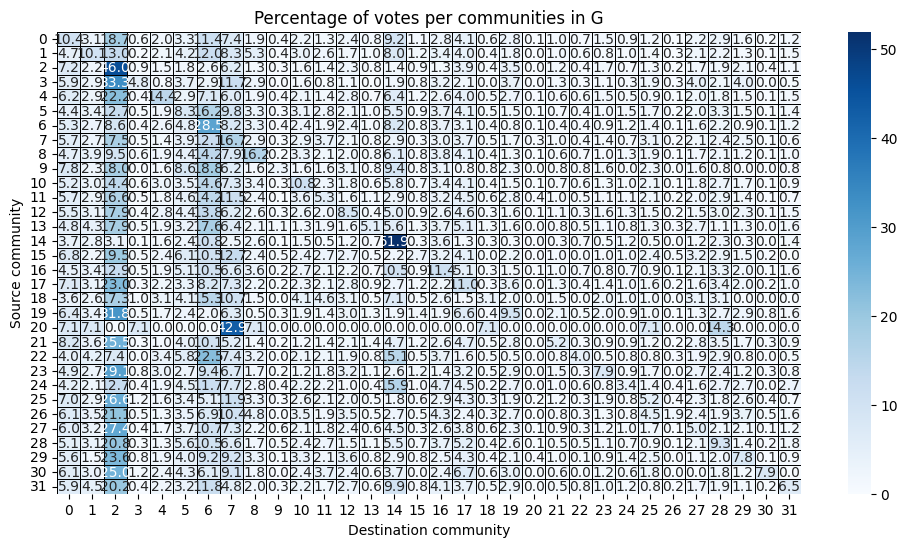

In [26]:
# heatmap of the ratio of votes across communities
plt.figure(figsize=(12, 6))
sns.heatmap(ratio_vote_count_matrix, cmap="Blues", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

We want to know the voting habitudes of communities. For that we plot the result precentage per community

In [27]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [28]:
vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100

C:\Users\danie\AppData\Local\Temp\ipykernel_25504\1177325575.py:1: RuntimeWarning: invalid value encountered in divide
  vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100


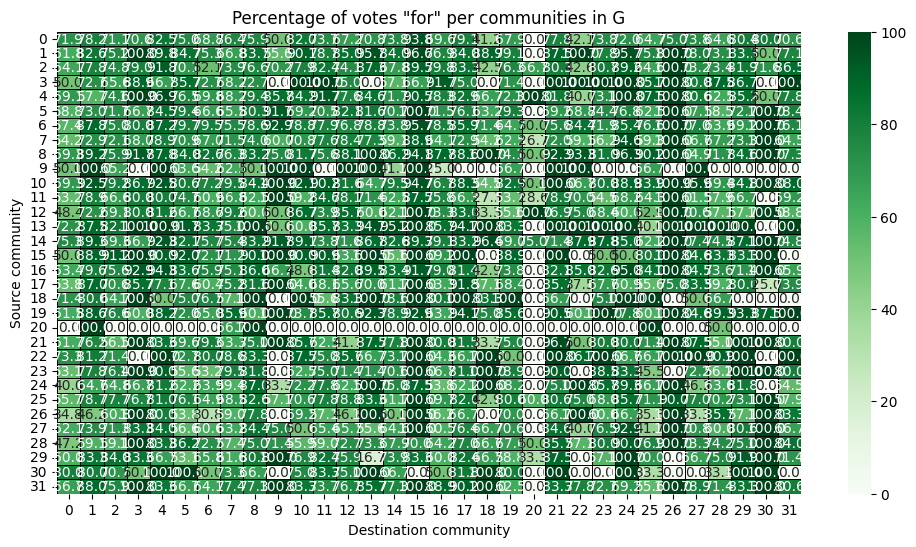

In [29]:
for_ratio_result_matrix = vote_result_matrix[:,:,2]
plt.figure(figsize=(24, 12))
sns.heatmap(for_ratio_result_matrix, cmap="Greens", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"for\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

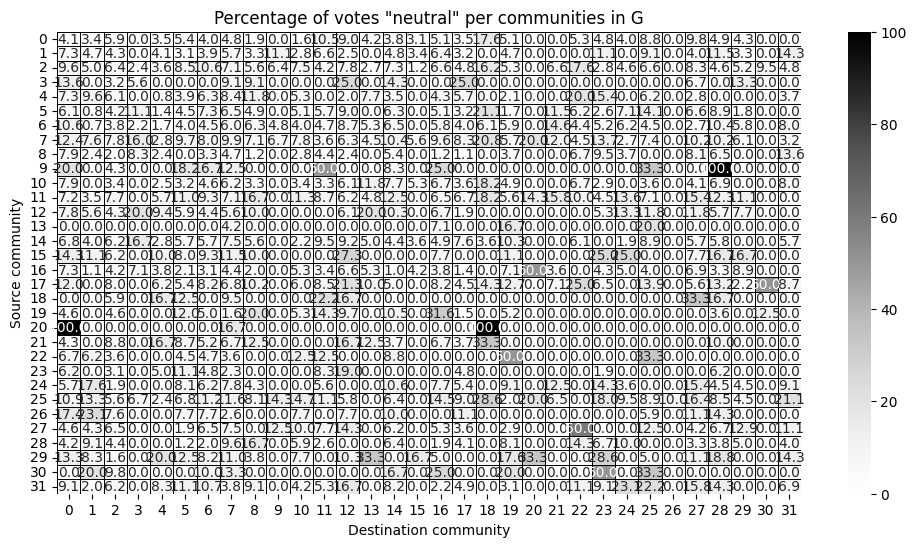

In [30]:
neutral_ratio_result_matrix = vote_result_matrix[:,:,1]
plt.figure(figsize=(24, 12))
sns.heatmap(neutral_ratio_result_matrix, cmap="Greys", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"neutral\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

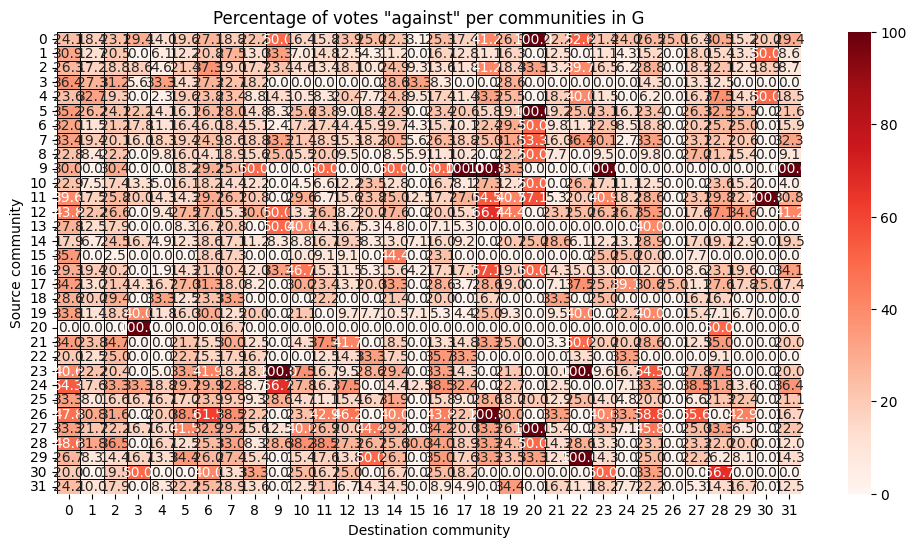

In [31]:
against_ratio_result_matrix = vote_result_matrix[:,:,0]
plt.figure(figsize=(24, 12))
sns.heatmap(against_ratio_result_matrix, cmap="Reds", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"against\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

In [32]:
#create matrix that represents the probability of a vote between two communities
prob_vote_community_matrix = np.zeros((len(communities), len(communities)))
for i_src in range(len(communities)):
    for i_dst in range(len(communities)):
        prob_vote_community_matrix[i_src][i_dst] = (len(communities[i_src])*len(communities[i_dst]))/(len(G)**2)
# create matrix that represents the expected number of votes between two communities
ratio_vote_expected_matrix = prob_vote_community_matrix * votes_in_the_graph

In [33]:
gain_vote_expected_matrix = np.nan_to_num(nb_result_votes / ratio_vote_expected_matrix)

In [35]:
import matplotlib.colors as colors

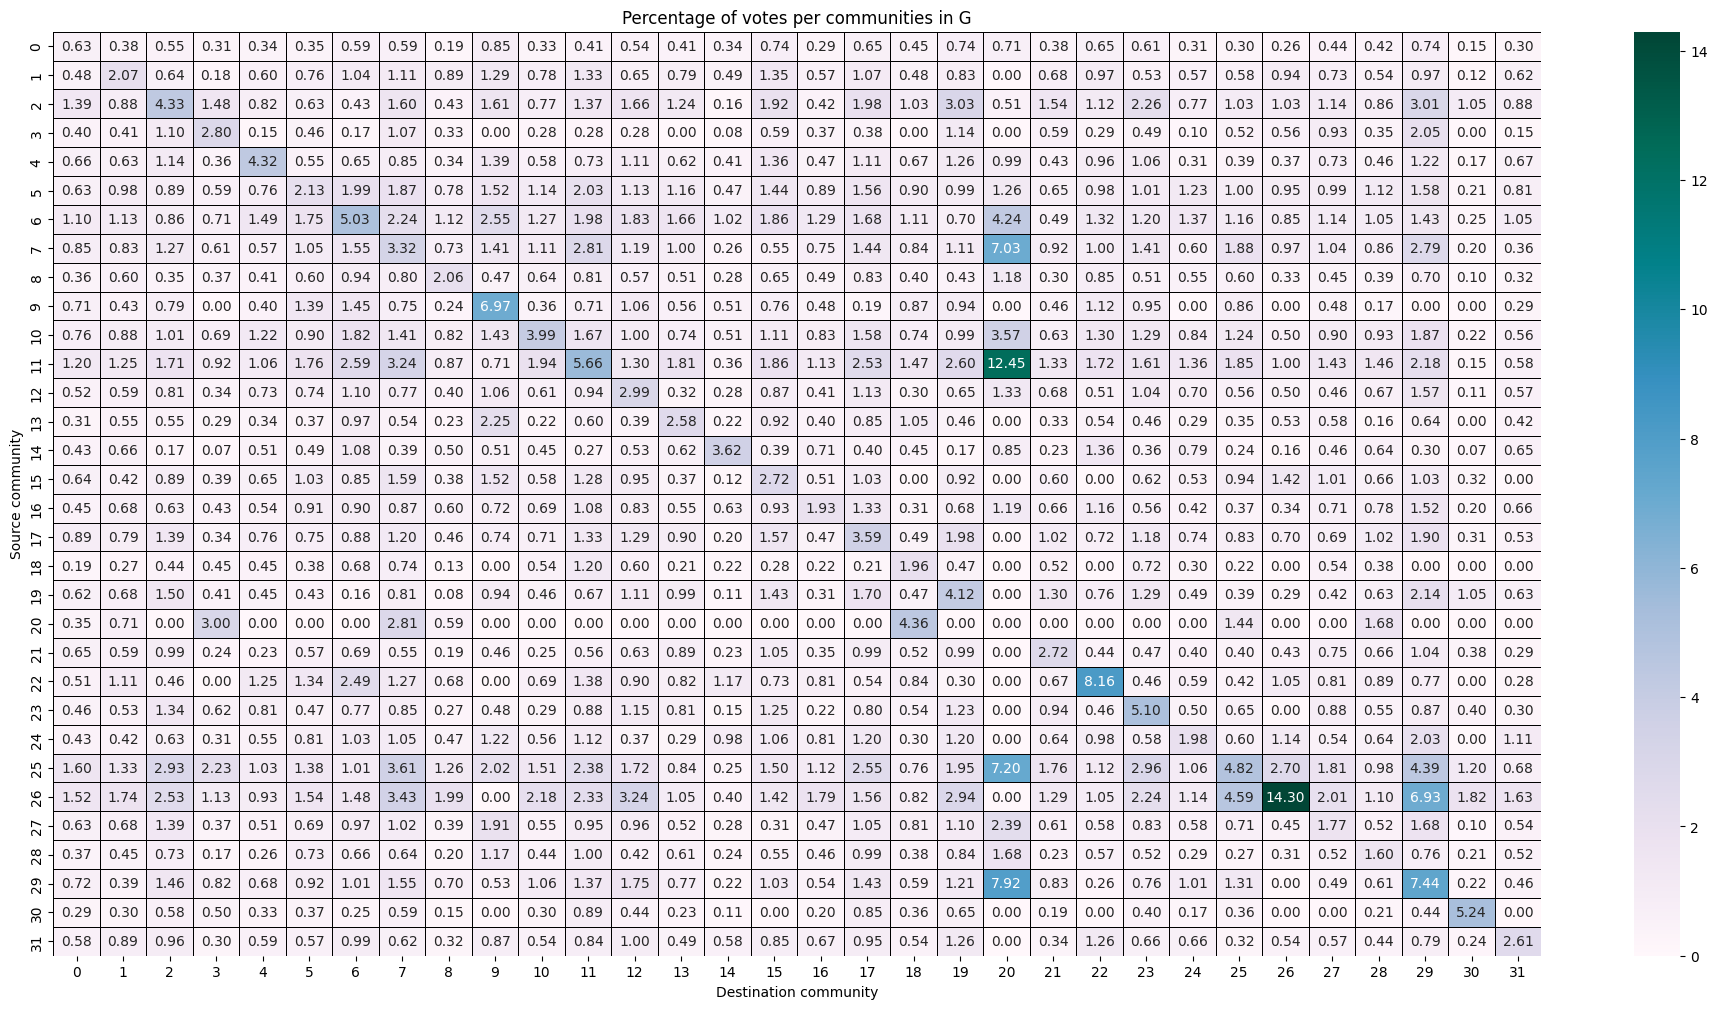

In [41]:
# heatmap of the gain from expected votes across communities
plt.figure(figsize=(24, 12))
sns.heatmap(gain_vote_expected_matrix, cmap="PuBuGn", annot=True, fmt=".2f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

In [37]:
gain_vote_expected_matrix[20][20]

0.0